<a href="https://colab.research.google.com/github/abhiiyer/ERA1/blob/main/Session-8/ERA1_S8_Normalization_Regularization_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified

Training Group Normalization model:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
            Conv2d-2           [-1, 32, 32, 32]           4,640
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           9,248
            Conv2d-5           [-1, 64, 16, 16]          18,496
         MaxPool2d-6             [-1, 64, 8, 8]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Linear-8                   [-1, 10]             650
Total params: 33,482
Trainable params: 33,482
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.66
Params size (MB): 0.13
Estimated Total Size (MB): 0

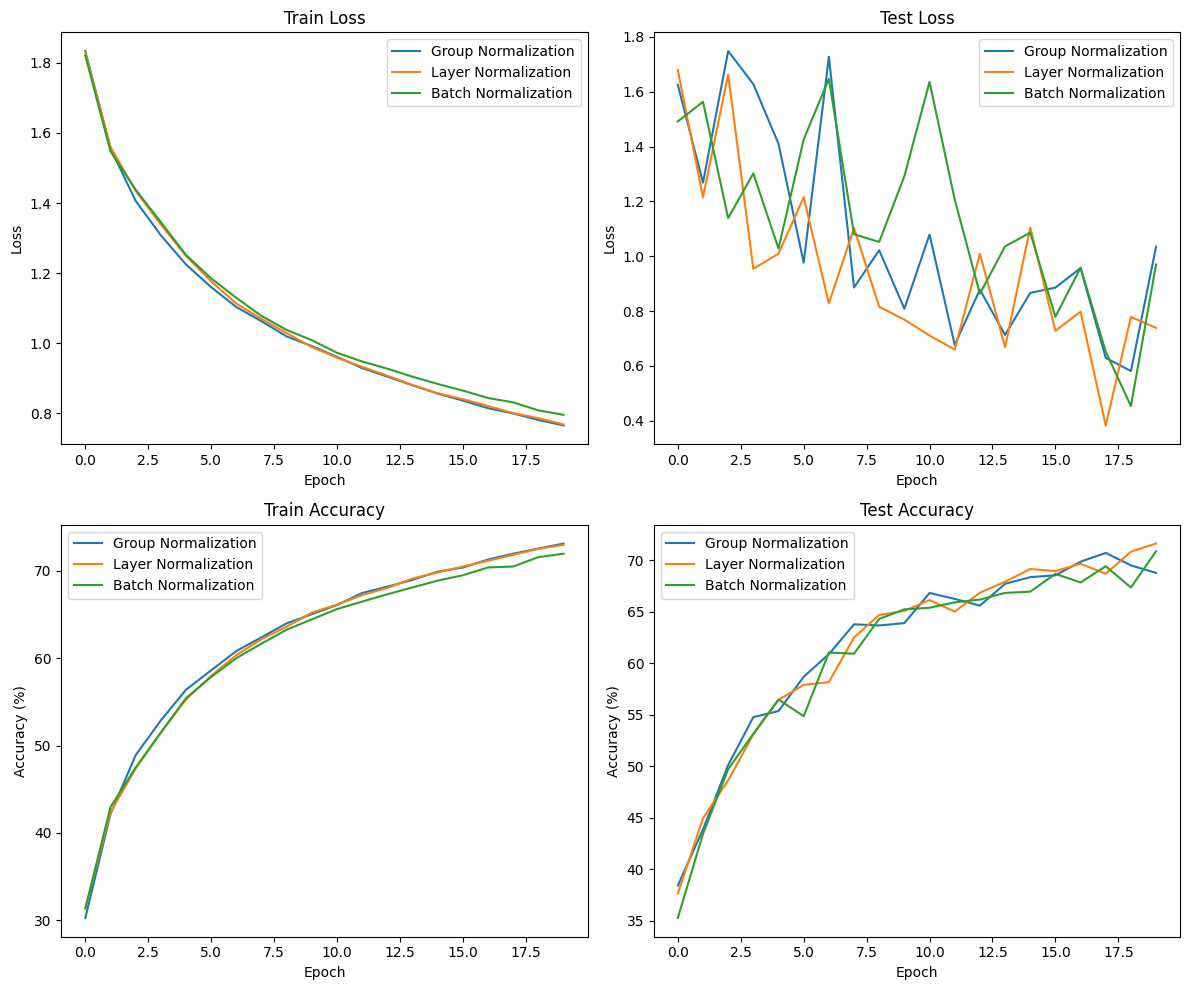

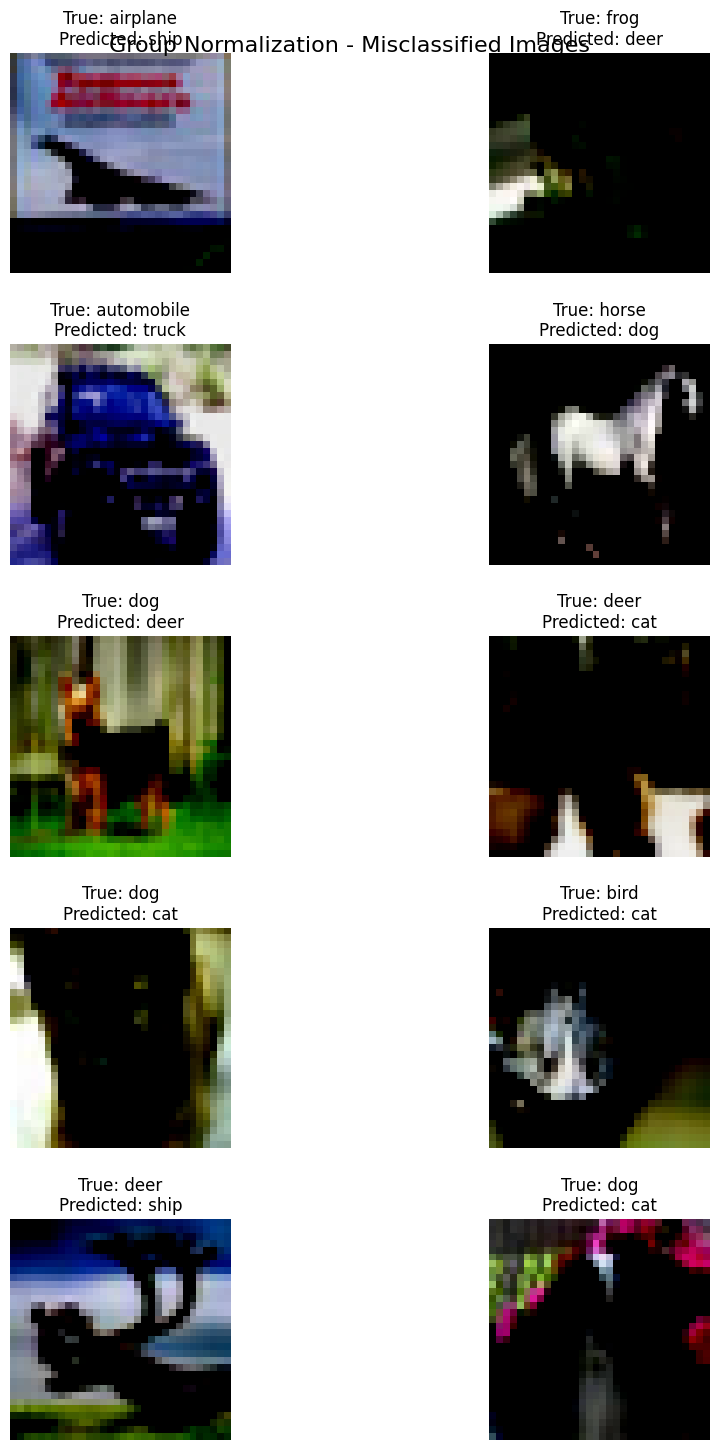

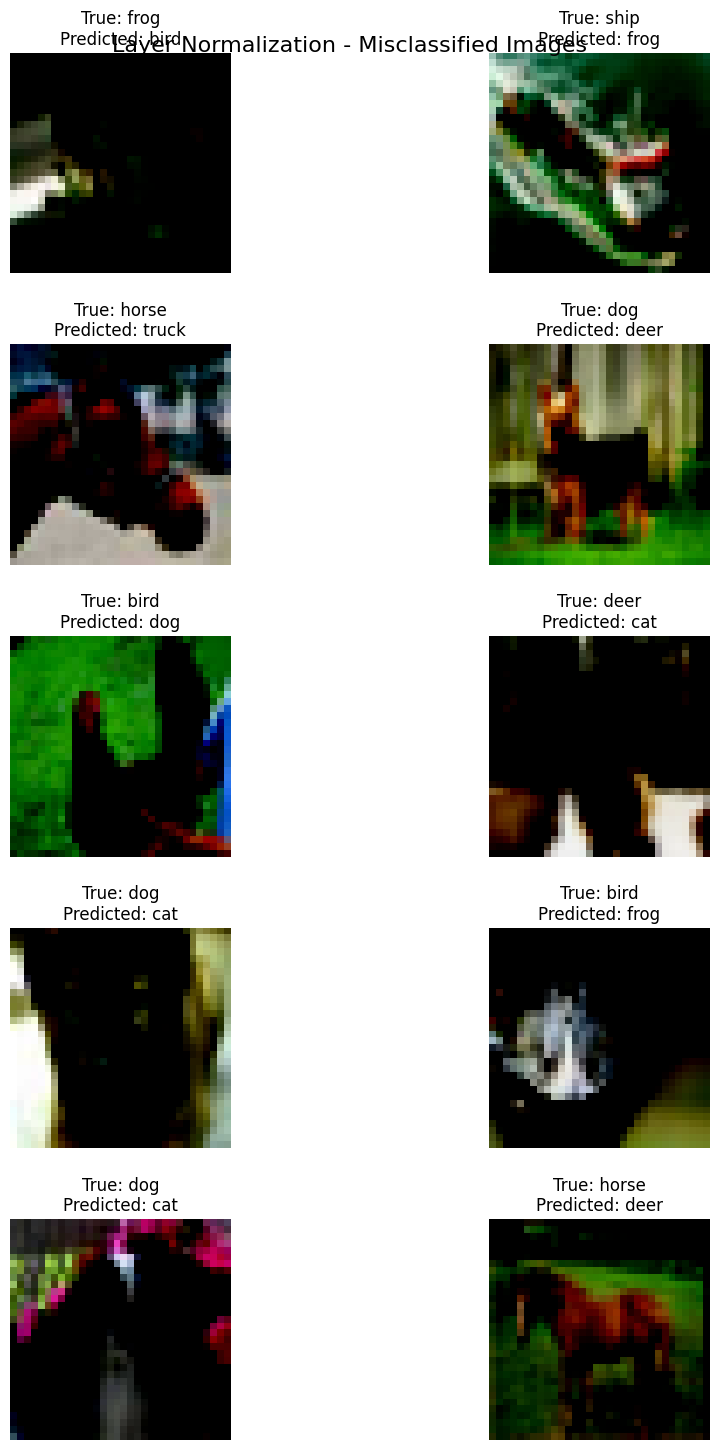

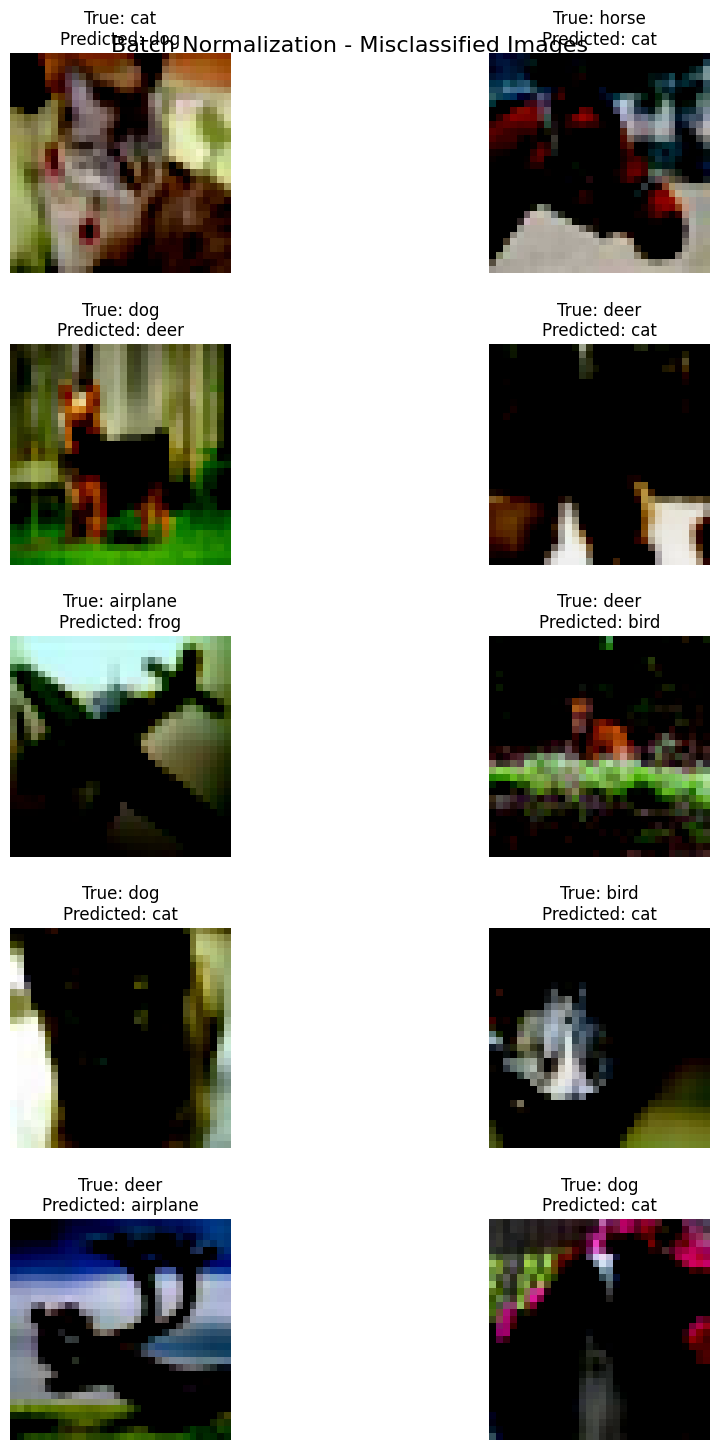

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms and load CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# Define the network architecture
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, 10)

        # Initialize the weights
        self._initialize_weights()

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.pool1(x)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.gap(x)
        x = x.view(-1, 64)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Training function
def train(net, criterion, optimizer, trainloader, max_epochs):
    net.train()
    max_train_acc = 0.0
    max_test_acc = 0.0
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(max_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / (i + 1)
        train_acc = 100.0 * correct / total
        test_acc = evaluate(net, testloader)
        test_loss = criterion(outputs, labels).item()

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if train_acc > max_train_acc:
            max_train_acc = train_acc
        if test_acc > max_test_acc:
            max_test_acc = test_acc

        print(f"Epoch {epoch + 1}/{max_epochs} Loss: {train_loss:.3f} Train Accuracy: {train_acc:.2f}% Test Accuracy: {test_acc:.2f}%")

    return max_train_acc, max_test_acc, train_losses, test_losses, train_accuracies, test_accuracies

# Evaluation function
def evaluate(net, dataloader):
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100.0 * correct / total
    return accuracy

# Initialize the models
models = {
    'Group Normalization': MyNetwork().to(device),
    'Layer Normalization': MyNetwork().to(device),
    'Batch Normalization': MyNetwork().to(device)
}

# Set hyperparameters
criterion = nn.CrossEntropyLoss()
max_epochs = 20
lr = 0.001

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name} model:")
    if name == 'Group Normalization':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif name == 'Layer Normalization':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif name == 'Batch Normalization':
        optimizer = optim.Adam(model.parameters(), lr=lr)

    summary(model, (3, 32, 32))  # Print model summary

    max_train_acc, max_test_acc, train_losses, test_losses, train_accuracies, test_accuracies = train(model, criterion, optimizer, trainloader, max_epochs)
    print(f"\n{name} model - Max Training Accuracy: {max_train_acc:.2f}%, Max Test Accuracy: {max_test_acc:.2f}%")

    # Parameter summary
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {total_params}")

    # Save results
    results[name] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }

# Plot train/test loss and accuracy graphs
plt.figure(figsize=(12, 10))
for name, result in results.items():
    train_losses = result['train_losses']
    test_losses = result['test_losses']
    train_accuracies = result['train_accuracies']
    test_accuracies = result['test_accuracies']

    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label=f"{name}")
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(test_losses, label=f"{name}")
    plt.title('Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(train_accuracies, label=f"{name}")
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(test_accuracies, label=f"{name}")
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

plt.tight_layout()
plt.show()

# Find misclassified images for each model
misclassified_images = {}
for name, model in models.items():
    misclassified_images[name] = []
    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            misclassified_idx = (predicted != labels).nonzero().squeeze()
            for idx in misclassified_idx:
                misclassified_images[name].append((images[idx].cpu(), labels[idx].cpu(), predicted[idx].cpu()))

# Show 10 misclassified images for each model as a 5x2 image matrix
for name, images in misclassified_images.items():
    fig, axs = plt.subplots(5, 2, figsize=(10, 15))
    fig.tight_layout(pad=3.0)
    fig.suptitle(f"{name} - Misclassified Images", fontsize=16)

    for i, (image, true_label, predicted_label) in enumerate(images[:10]):
        ax = axs[i // 2, i % 2]
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.axis('off')
        true_class = testset.classes[true_label]
        predicted_class = testset.classes[predicted_label]
        ax.set_title(f"True: {true_class}\nPredicted: {predicted_class}")

    plt.show()
